In [ ]:
##### !!!! Ensure you have Italo's n_back_spatial_task.py in the same directory as this file !!!! ##### 
from lstm_explorer import (
    NBackLoss,
    test,
    sample_and_train,
    create_n_back_dataset,
    DataLoader
)
import torch
from lstm_plots import plot_tsne, plot_spatial_correlation, accuracy_results
import matplotlib.pyplot as plt
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  


=== Training N=0 ===


/Users/neur1s/miniconda3/.conda/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Done!


/Users/neur1s/miniconda3/.conda/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/neur1s/miniconda3/.conda/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


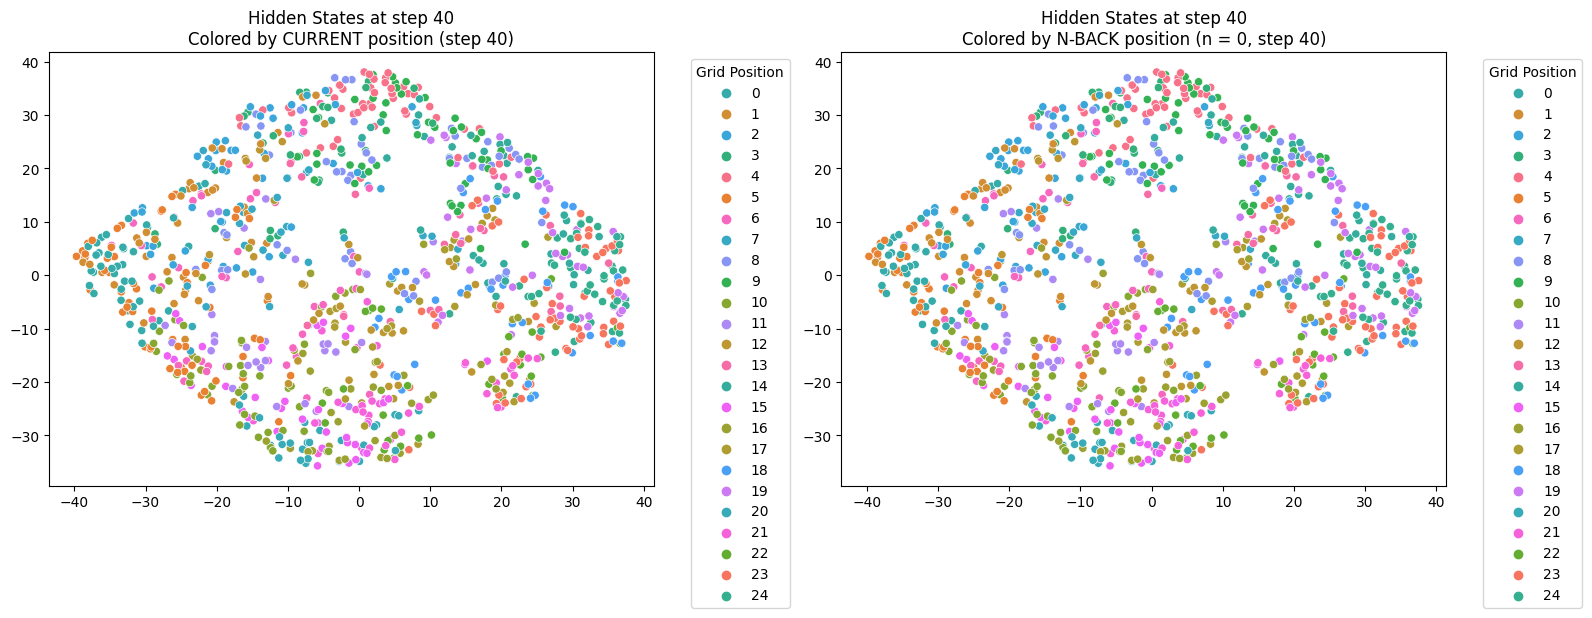

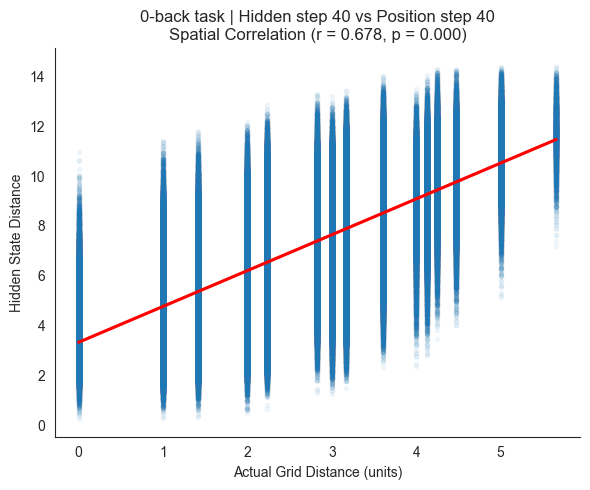


=== Training N=1 ===


/Users/neur1s/miniconda3/.conda/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10e1ee850>>
Traceback (most recent call last):
  File "/Users/neur1s/miniconda3/.conda/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Epoch 4
-------------------------------
Epoch 5
-------------------------------


In [ ]:
def run_experiment(max_n=10):
    accuracies = []
    spatial_corrs = []
    
    for N in range(max_n + 1):
        print(f"\n=== Training N={N} ===")
        model, acc, test_loss, train_loss, test_dataloader = sample_and_train(N, hidden_units=256)
        
        if N in [0, 5, 10]:
            # Ensure we get valid data by:
            # 1. Using a time step that's guaranteed to have n-back positions
            # 2. Creating a fresh dataloader with sufficient sequence length
            seq_length = 50 + N  # Ensure enough history for n-back
            analysis_dataloader = DataLoader(
                create_n_back_dataset(1000, N, max_length=seq_length, boundary='strict'),
                batch_size=100
            )
            
            # Choose a time step safely in the middle
            time_step = 40 + N  # Adjusted to ensure n-back positions exist
            
            # Get hidden states and labels - now guaranteed to have data
            _, _, hidden_states, current_labels, nback_labels = test(
                analysis_dataloader, model, NBackLoss(N),
                return_hidden=True, time_step=time_step
            )
            
            # Verify we have data
            assert len(hidden_states) > 0, f"No hidden states collected for N={N}"
            assert len(current_labels) > 0, f"No current labels collected for N={N}"
            if N > 0:
                assert len(nback_labels) > 0, f"No n-back labels collected for N={N}"
            
            # Now we can safely plot
            plot_tsne(hidden_states, current_labels, nback_labels, N, time_step)
            corr = plot_spatial_correlation(hidden_states, current_labels, hidden_step=time_step, N=N)
            spatial_corrs.append(corr)
            
            if N > 0:
                plot_spatial_correlation(hidden_states, nback_labels, hidden_step=time_step, N=N)
            
            accuracies.append(acc[-1])
        else:
            accuracies.append(acc[-1])
    
    return accuracies, spatial_corrs

if __name__ == "__main__":
    accuracies, spatial_corrs = run_experiment()
    
accuracy_results(accuracies)